<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Alison Cortesi / Germain Lefebvre / Florent Morin / Vincent Bilger</center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

* [0 - Importation des ressources](#chapter0)
    * [Complément - BDD globale:](#chapter0.complement)
* [I - Conversion des données en rendements logarithmiques](#chapter1)
    * [Complétement : Modélisation d'une portefeuille d'actions pondéré](#chapter1.complement)
    
* [II - Préparation de notre data set pour la simulation ](#chapter2)

* [III - Premières modélisations - Plusieurs méthodes paramétriques](#chapter3)
    * [III.1  Préparation de 3 modèles paramétriques](#chapter3.section1) 
        * [III.1.1 - Modèle AR(1)](#chapter3.section1.1)
        * [II.1.2 - Modèle GARCH(1,1)](#chapter3.section1.2)
        * [III.1.3 - Modèle EGARCH(1,1)](#chapter3.section1.3)
    * [III.2 - Simulations grâce à nos modèles](#chapter3.section2)
        * [II.2.1 - Simulation avec AR(1)](#chapter3.section2.1)
        * [III.2.2 - Simulation avec EGARCH(1,1)](#chapter3.section2.2)
        * [III.2.3 - Simulation avec GARCH(1,1)](#chapter3.section2.3)
        * [III.2.4 - Simulation avec FHS (AR et GARCH)](#chapter3.section2.4)
        
* [IV- Bootstrapping & 1ère analyse](#chapter4)
    * [IV.1 - Bootstrapping](#chapter4.section1)
    * [IV.2 - Première analyse](#chapter4.section2)
    * [IV.3 - Comparaison avec les valeurs réelles](#chapter4.section3)
    
* [V - Fonction Prediction_Boostrapping](#chapter5)

* [VI - Fonction de performance](#chapter6) 
    * [VI.1 - Fonctions de mesures](#chapter6.section1)
    * [VI.2 - Fonction Describe](#chapter6.section2)
    * [VI.3 - Comparaison des prévisions par boostrapping et des modèles AR(1), GARCH(1,1) et AR(1)-GARCH(1,1)](#chapter6.section3)


## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [2]:
conda install -c conda-forge statsmodels

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c saravji pmdarima

In [3]:
import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section
import datetime                                           #Used in section 0
from datetime import date                                 #Used in section 0
from statsmodels.tsa.arima_model import ARIMA             #Used in section 3.1.1
from statsmodels.graphics.tsaplots import plot_acf        #Used in section 3.1.2 et 3.1.3
from arch import arch_model                               #Used in section 3.1.2 et 3.1.3
import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
#import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [4]:
#root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/'                          #Germain
#root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
#root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
                                                                                                   #Alison
#root_path = 'D:/Utilisateurs/JLEQ/BP2                                                             #Julien

Importation des BDD utiles pour le test : 

- Actions : Stoxx50 & SP 500
- Taux : USD/EUR et EURibor 3M

D'un côté, les actions (STOXX50 et SP500) dont le cours est présenté en variations pleines, et d'un autre côté les taux (LIBOR, USD/EUR) dont le cours varie en pourcentage.

In [9]:
#Actions
STOXX50 = pd.read_csv(root_path+'^STOXX50E.csv')
SP500 = pd.read_csv(root_path+'historic_SP500_XCME_USD_newvirgule.csv')

#Taux
USDEUR = pd.read_csv(root_path+'USDEUR.csv')
EUR3MTD156 = pd.read_csv(root_path+'EUR3MTD156N.csv')

#Fusion des données des actions et conversion du type des dates
data=pd.merge(STOXX50, SP500, how='inner', on='Date')

data['Date'] = pd.to_datetime(data['Date'])
USDEUR['Date'] = pd.to_datetime(USDEUR['Date'])
EUR3MTD156['DATE'] = pd.to_datetime(EUR3MTD156['DATE'])

dates = np.array(data.Date, dtype=np.datetime64)
datesfx= np.array(USDEUR.Date, dtype=np.datetime64)
datelibor=np.array(EUR3MTD156.DATE, dtype=np.datetime64)


#pour rendre les données du LIBOR numériques, en remplissant chaque cellules vide par la donnée précédente
EUR3MTD156.EUR3MTD156N=pd.to_numeric(EUR3MTD156.EUR3MTD156N, errors='coerce')
EUR3MTD156.ffill(axis = 0)


#DataFrames pour les différentes données, une date par ligne
data=pd.DataFrame({ 'Stoxx50 Index' : list(data.Close_x) , 'S&P500 Index' : list(data.Close_y) },index=data['Date'])
USDEUR=pd.DataFrame({'USD/EUR Index' : list(USDEUR.Close)}, index=USDEUR['Date'])
EUR3MTD156=pd.DataFrame({'LIBOR 3M Index' : list(EUR3MTD156.EUR3MTD156N)}, index=EUR3MTD156['DATE'])

In [10]:
#Actions
STOXX50 = pd.read_csv(root_path+'^STOXX50E.csv')
SP500 = pd.read_csv(root_path+'historic_SP500_XCME_USD_newvirgule.csv')
data=pd.merge(STOXX50, SP500, how='inner', on='Date')
data['Date'] = pd.to_datetime(data['Date'])
dates = np.array(data.Date, dtype=np.datetime64)
data=pd.DataFrame({ 'Stoxx50 Index' : list(data.Close_x) , 'S&P500 Index' : list(data.Close_y) },index=data['Date'])



In [11]:
Taux = pd.read_csv(root_path+'BDD_Rates.csv')

In [12]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')

In [13]:
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')

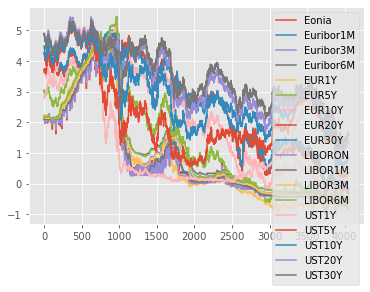

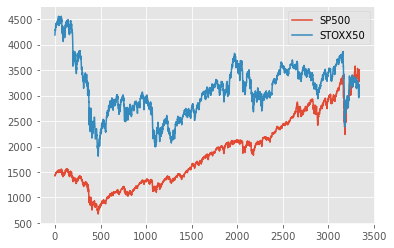

In [14]:
Taux.plot()
Actions.plot()

On peut afficher les courbes afin de visionner une première fois les bases de données chargées.

Text(0.5, 1.0, 'Daily Changes in LIBOR 3M Index')

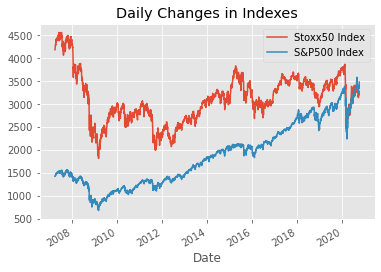

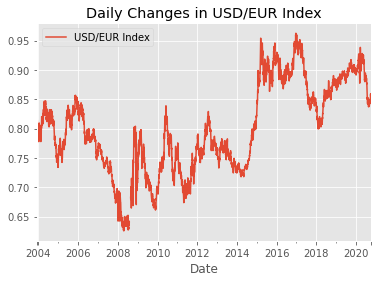

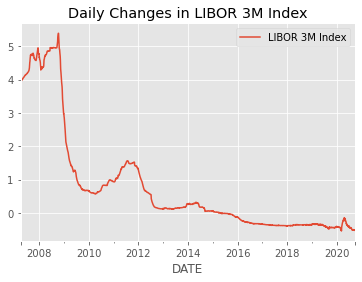

In [15]:
#plot des données brutes
data.plot()
plt.title('Daily Changes in Indexes')
USDEUR.plot()
plt.title('Daily Changes in USD/EUR Index')
EUR3MTD156.plot()
plt.title('Daily Changes in LIBOR 3M Index')

Text(0.5, 1.0, 'Daily Changes in Indexes')

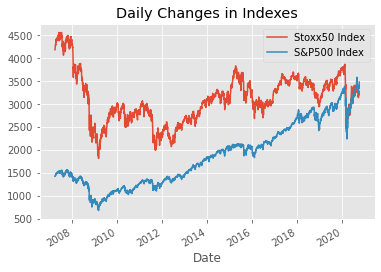

In [16]:
data.plot()
plt.title('Daily Changes in Indexes')

## FM -> A changer avec actuel
<h6>Complément - BDD globale: </h6>  <a class="anchor" id="chapter0.complement"></a>

Afin de pouvoir étudier un panel important de données, et notamment des taux, nous allons importer un grand nombre de fichier.
Dans un premier temps, toutes les données importées ci-dessous ne seront pas utilisées.
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 

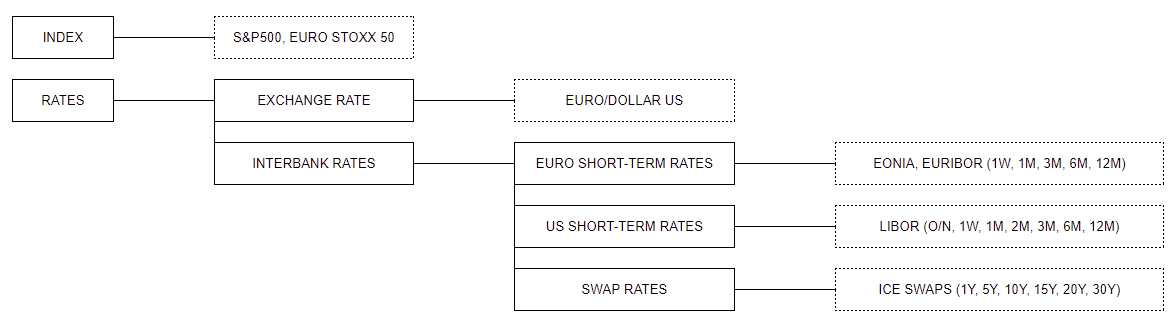

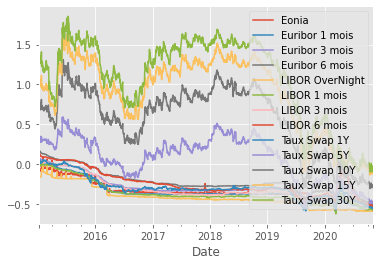

In [17]:
EONIA = pd.read_csv(root_path+'EONIA.csv',delimiter=';',header=5) # ouvre les fichiers csv
EONIA.rename(columns={ EONIA.columns[0]: "Date",EONIA.columns[1]: "Eonia" }, inplace = True)
EONIA['Date'] = pd.to_datetime(EONIA.Date)
EONIA['Date'] = EONIA['Date'].dt.strftime('%d/%m/%Y')
EONIA['Date'] = pd.to_datetime(EONIA.Date)

EUR1M = pd.read_csv(root_path+'EUR1M.csv',delimiter=';',header=5,error_bad_lines=False) # ouvre les fichiers csv
EUR1M.rename(columns={ EUR1M.columns[0]: "Date",EUR1M.columns[1]: "Euribor 1 mois" }, inplace = True)
EUR1M['Date'] = pd.to_datetime(EUR1M.Date)
EUR1M['Date'] = EUR1M['Date'].dt.strftime('%d/%m/%Y')
EUR1M['Date'] = pd.to_datetime(EUR1M.Date)

EUR3M = pd.read_csv(root_path+'EUR3M.csv',delimiter=';',header=5,error_bad_lines=False) # ouvre les fichiers csv
EUR3M.rename(columns={ EUR3M.columns[0]: "Date",EUR3M.columns[1]: "Euribor 3 mois" }, inplace = True)
EUR3M['Date'] = pd.to_datetime(EUR3M.Date)
EUR3M['Date'] = EUR3M['Date'].dt.strftime('%d/%m/%Y')
EUR3M['Date'] = pd.to_datetime(EUR3M.Date)

EUR6M = pd.read_csv(root_path+'EUR6M.csv',delimiter=';',header=5,error_bad_lines=False) # ouvre les fichiers csv
EUR6M.rename(columns={ EUR6M.columns[0]: "Date",EUR6M.columns[1]: "Euribor 6 mois" }, inplace = True)
EUR6M['Date'] = pd.to_datetime(EUR6M.Date)
EUR6M['Date'] = EUR6M['Date'].dt.strftime('%d/%m/%Y')
EUR6M['Date'] = pd.to_datetime(EUR6M.Date)

LIBON = pd.read_csv(root_path+'LIBON.csv')
LIBON.rename(columns={ LIBON.columns[0]: "Date",LIBON.columns[1]: "LIBOR OverNight" }, inplace = True)
LIBON['Date'] = pd.to_datetime(LIBON.Date)

LIB1M = pd.read_csv(root_path+'LIB1M.csv')
LIB1M.rename(columns={ LIB1M.columns[0]: "Date",LIB1M.columns[1]: "LIBOR 1 mois" }, inplace = True)
LIB1M['Date'] = pd.to_datetime(LIB1M.Date)

LIB3M = pd.read_csv(root_path+'LIB3M.csv')
LIB3M.rename(columns={ LIB3M.columns[0]: "Date",LIB3M.columns[1]: "LIBOR 3 mois" }, inplace = True)
LIB3M['Date'] = pd.to_datetime(LIB3M.Date)

LIB6M = pd.read_csv(root_path+'LIB6M.csv')
LIB6M.rename(columns={ LIB6M.columns[0]: "Date",LIB6M.columns[1]: "LIBOR 6 mois" }, inplace = True)
LIB6M['Date'] = pd.to_datetime(LIB6M.Date)

SW1Y = pd.read_csv(root_path+'SW1YVSEUR3M.csv')
SW1Y.rename(columns={ SW1Y.columns[0]: "Date",SW1Y.columns[1]: "Taux Swap 1Y" }, inplace = True)
SW1Y['Date'] = pd.to_datetime(SW1Y.Date)

SW5Y = pd.read_csv(root_path+'SW5YVSEUR6M.csv')
SW5Y.rename(columns={ SW5Y.columns[0]: "Date",SW5Y.columns[1]: "Taux Swap 5Y" }, inplace = True)
SW5Y['Date'] = pd.to_datetime(SW5Y.Date)

SW10Y = pd.read_csv(root_path+'SW10YVSEUR6M.csv')
SW10Y.rename(columns={ SW10Y.columns[0]: "Date",SW10Y.columns[1]: "Taux Swap 10Y" }, inplace = True)
SW10Y['Date'] = pd.to_datetime(SW10Y.Date)

SW15Y = pd.read_csv(root_path+'SW15YVSEUR6M.csv')
SW15Y.rename(columns={ SW15Y.columns[0]: "Date",SW15Y.columns[1]: "Taux Swap 15Y" }, inplace = True)
SW15Y['Date'] = pd.to_datetime(SW15Y.Date)

SW30Y = pd.read_csv(root_path+'SW30YVSEUR6M.csv')
SW30Y.rename(columns={ SW30Y.columns[0]: "Date",SW30Y.columns[1]: "Taux Swap 30Y" }, inplace = True)
SW30Y['Date'] = pd.to_datetime(SW30Y.Date)

Data_EU=pd.merge(EONIA, pd.merge(EUR1M, pd.merge(EUR3M, EUR6M, how='inner', on='Date'), how='inner', on='Date'), how='inner', on='Date', left_index=True) # regroupe les indices concernés par date
Data_US=pd.merge(LIBON, pd.merge(LIB1M, pd.merge(LIB3M, LIB6M, how='inner', on='Date'), how='inner', on='Date'), how='inner', on='Date', left_index=True) # regroupe les indices concernés par date
Data_SW=pd.merge(SW1Y, pd.merge(SW5Y, pd.merge(SW10Y, pd.merge(SW15Y, SW30Y, how='inner', on='Date'), how='inner', on='Date'), how='inner', on='Date'), how='inner', on='Date', left_index=True) # regroupe les indices concernés par date

Data_EU['Date'] = pd.to_datetime(Data_EU['Date'])
Data_US['Date'] = pd.to_datetime(Data_US['Date'])
Data_SW['Date'] = pd.to_datetime(Data_SW['Date'])

Merge = pd.merge(Data_EU,pd.merge(Data_US,Data_SW,how='inner',on='Date'),how='inner',on='Date')
Data = pd.DataFrame(Merge.iloc[:,1:])
Data.index=Merge['Date']
Data = Data.iloc[1:]

for i in Data:
    for j in range(0,len(Data[i])):
        if str(Data[i][j])=='nan':
            Data[i][j]=Data[i][j-1]
        if str(Data[i][j])=='':
            Data[i][j]=Data[i][j-1]
        if str(Data[i][j])=='.':
            Data[i][j]=Data[i][j-1]
        if str(Data[i][j])=='-':
            Data[i][j]=Data[i][j-1]
            
Data = pd.concat([Data[col].str.split().str[0].str.replace(',','.').astype(float) for col in Data], axis=1)

Data.to_csv(root_path+'BDD.csv', index = False)

Data.plot()          
    

<h5> IMPORTANT : </h5> 

Dans une version ultérieur du code, nous simplifirons la démarche en utilisant uniquement les requêtes vers le fichier BDD créée. Ainsi, il n'y aura plus qu'un seul fichier CSV utilisé lors de l'ensemble du projet.

## I - Conversion des données en rendements logarithmiques <a class="anchor" id="chapter1"></a>

[Retour Sommaire](#sommaire)

On commence par normaliser les donneés en divisant chaque donnée par la valeur initiale de la série.

$$ r_{t} = \frac{Data_{t}}{Data_{0}} $$

Puis on passe au logarithme : 

$$ Return(t) = \ln(1 + r_{t}) $$


##### Liens utiles : 
* https://stackoverflow.com/questions/49352551/pandas-how-to-get-close-price-from-returns
* https://subscription.packtpub.com/book/data/9781789618518/1/ch01lvl1sec05/converting-prices-to-returns

In [63]:
#On calcul le pourcentage de variation pour chacune nos deux actions :
r_S50 = data[['Stoxx50 Index']].pct_change().dropna()
r_SP = data[['S&P500 Index']].pct_change().dropna()

#On prend le logarithme pour obtenir nos rendements logarithmiques
returns_S50 = np.log(1 + r_S50)
returns_SP = np.log(1 + r_SP)

In [19]:
#Affichage des rendements logarithmiques
print(returns_S50)
print(returns_SP)

            Stoxx50 Index
Date                     
2007-04-02       0.002036
2007-04-03       0.013455
2007-04-04       0.003651
2007-04-05       0.002276
2007-04-10       0.006982
...                   ...
2020-10-05       0.009137
2020-10-06       0.004054
2020-10-07       0.000040
2020-10-08       0.006882
2020-10-09       0.005318

[3319 rows x 1 columns]
            S&P500 Index
Date                    
2007-04-02      0.002594
2007-04-03      0.009237
2007-04-04      0.001112
2007-04-05      0.003045
2007-04-10      0.003202
...                  ...
2020-10-05      0.017813
2020-10-06     -0.014072
2020-10-07      0.017247
2020-10-08      0.007978
2020-10-09      0.008755

[3319 rows x 1 columns]


On peut maintenant afficher le rendement logarithmique journalier de nos actions : 

Text(0.5, 1.0, 'Daily Logarithmic Returns for S&P500 Index')

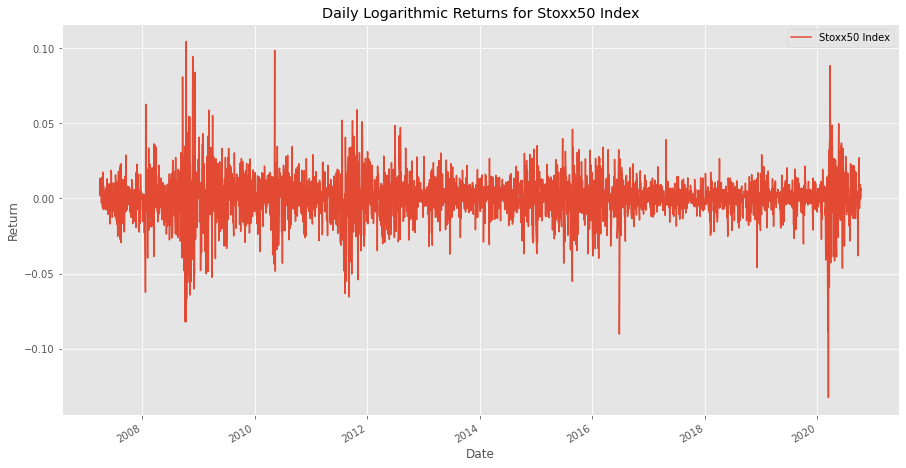

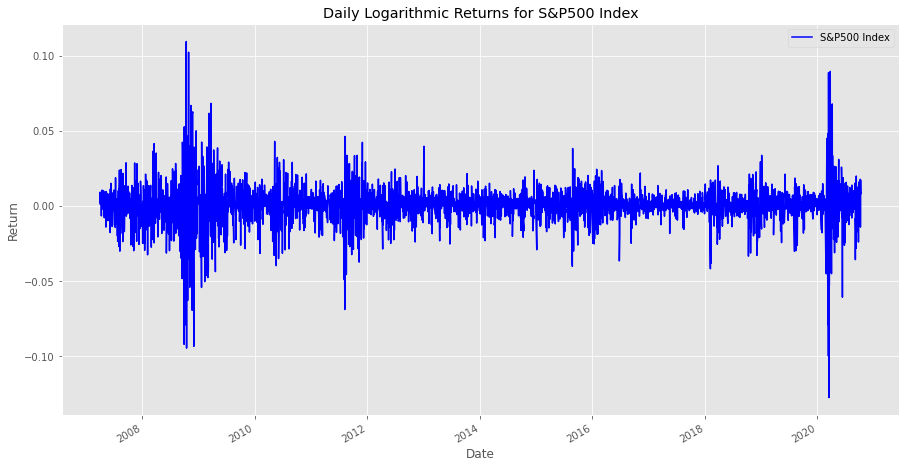

In [20]:
returns_S50.plot(figsize=(15, 8))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Logarithmic Returns for Stoxx50 Index')

returns_SP.plot(figsize=(15,8),color='b')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Logarithmic Returns for S&P500 Index')

<u>Remarque:</u> On voit bien les fortes varations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

#### Complétement : Modélisation d'une portefeuille d'actions pondéré <a class="anchor" id="chapter1.complement"></a>

Afin d'élargir l'utilité de notre projet, nous nous sommes laissés la possibilité de modéliser non pas une unique action mais aussi un portefeuille d'actions pondéré.

La modélisation de ce portefeuille est réalisée ci-dessous avec une pondération équivalente (50% - 50%) : 

In [21]:
#portefeuille pondéré (répartition à 50%)
data_pf=data.copy()
data_pf['Portfolio']=data_pf.mean(axis=1)

#Comme dans la partie précédente, on prend le pourcentage puis on passe au logarithme
r_portfolio = data.pct_change().dropna().mean(axis=1)
returns = np.log(1 + r_portfolio)

print(data)
print(data_pf)

            Stoxx50 Index  S&P500 Index
Date                                   
2007-03-30    4181.029785   1420.859985
2007-04-02    4189.549805   1424.550049
2007-04-03    4246.299805   1437.770020
2007-04-04    4261.830078   1439.369995
2007-04-05    4271.540039   1443.760010
...                   ...           ...
2020-10-05    3220.219971   3408.600098
2020-10-06    3233.300049   3360.969971
2020-10-07    3233.429932   3419.439941
2020-10-08    3255.760010   3446.830078
2020-10-09    3273.120117   3477.139893

[3320 rows x 2 columns]
            Stoxx50 Index  S&P500 Index    Portfolio
Date                                                
2007-03-30    4181.029785   1420.859985  2800.944885
2007-04-02    4189.549805   1424.550049  2807.049927
2007-04-03    4246.299805   1437.770020  2842.034912
2007-04-04    4261.830078   1439.369995  2850.600036
2007-04-05    4271.540039   1443.760010  2857.650025
...                   ...           ...          ...
2020-10-05    3220.219971   340

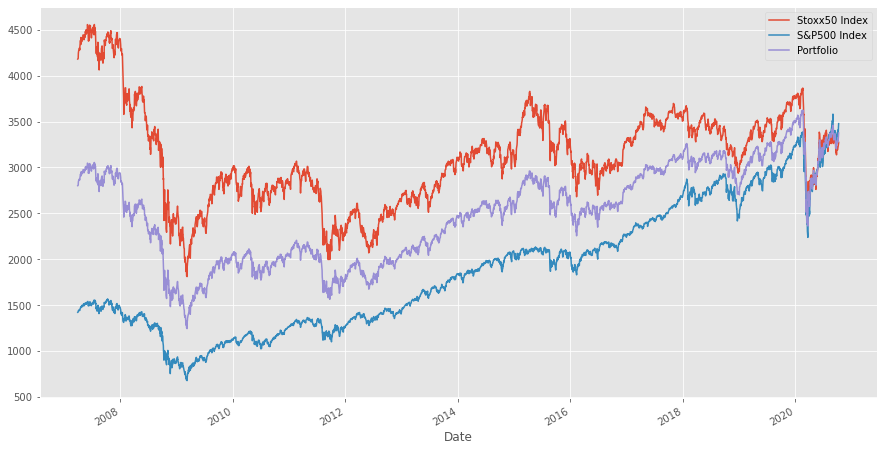

In [22]:
#Affichage des différentes courbes qui composent notre portfolio 
data_pf.plot(figsize=(15, 8))
plt.legend()
plt.show()

## II - Préparation de notre data set pour la simulation <a class="anchor" id="chapter2"></a>

[Retour Sommaire](#sommaire)

Dans la suite de ce paragraphe, on utilisera <strong> l'action Stoxx50 </strong>, plus précisément son <strong> rendement logarithmique </strong> associé.

On commence par séparer notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

In [64]:
#séparation en data training et data test
T=len(returns_S50.index)
T=int(np.floor(T*0.8))
training_data_S50 = returns_S50[0:T-1]
test_data_S50 = returns_S50[T:]

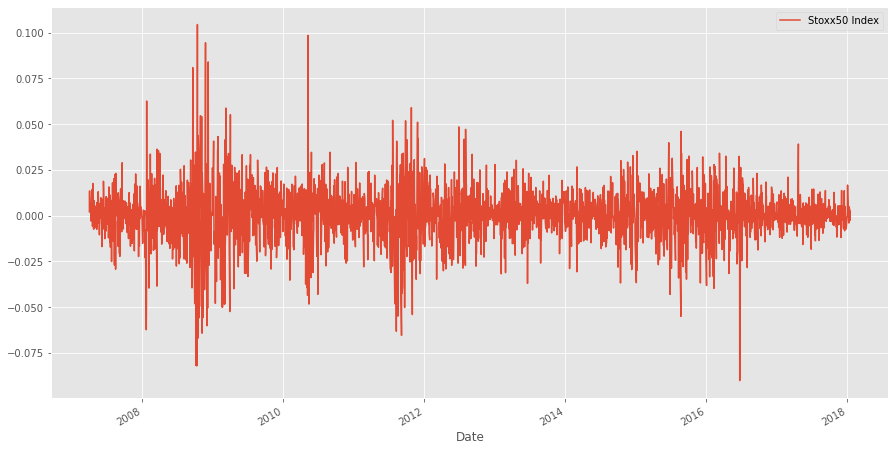

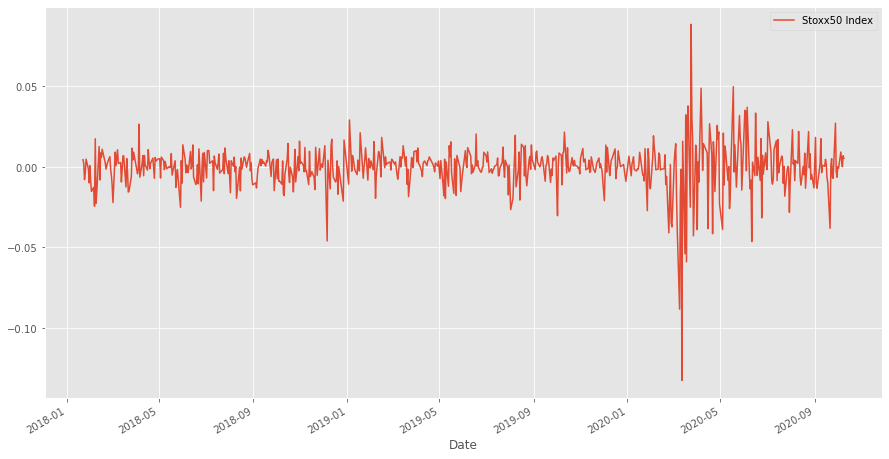

In [65]:
#On peut afficher le training set ou le testing set si besoin 
training_data_S50.plot(figsize=(15,8))
test_data_S50.plot(figsize=(15,8))

## III - Premières modélisations - Plusieurs méthodes paramétriques <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser des méthodes simples de modélisations et de prédictions. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ces méthodes simples afin de travailler sur des méthodes plus compliquées.

Nous en avons sélectionné trois.


### III.1  Préparation de 3 modèles paramétriques<a class="anchor" id="chapter3.section1"></a>

### III.1.1 - Modèle ARMA(p,q) <a class="anchor" id="chapter3.section1.1"></a>

On rappelle la forme de ce modèle ci-dessous : 

$$ X_{t}= c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t} + \sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}$$

où 
- $c$ : constante
- $\varepsilon _{t}$ : bruit blanc
- $\varphi _{i} $ , $ \theta _{i} $ : parametres du modèle 

Nous allons utiliser une fonction qui permet de retourner le meilleur processus ARIMA par minimisation du critére d'information AIC. Cette recherche de modèle n'est pas optimale mais elle nous permet de sélectionner très rapidement notre modèle pour la suite de nos travaux.

Documentation sur la fonction auto.arima

https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

In [37]:
import pmdarima as pm                                        
from pmdarima.arima import ARIMA                             

In [91]:
#The Auto-arima function will propose the best Arma-GARCH model for our returns
def best_param_ARIMA(training_data,p_max,q_max):
    stepwise_fit = pm.auto_arima(training_data, start_p=1, start_q=1, max_p=p_max, max_q=q_max, m=1,
                             start_P=0, seasonal=False, d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    return(stepwise_fit.summary())


Nous prendrons pour exemple le training set réalisé avec les <strong> rendements logarithmiques du Stoxx50 </strong>, mais cela peut s'appliquer avec d'autres modèles pour des training set contenant d'autres actions.

In [92]:
# On fait tourner notre fonction sur notre training set 
best_param_ARIMA(training_data_S50,3,3)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14688.420, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14690.588, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14691.259, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14691.600, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-14698.261, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-14699.022, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-14697.225, Time=1.71 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-14700.826, Time=1.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-14701.487, Time=0.84 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-14699.534, Time=1.63 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 7.852 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2654
Model:               SARIMAX(0, 0, 3)   Log Likelihood                7354.744
Date:                Sun, 06 Dec 2020   AIC                         -14701.487
Time:                        10:38:41   BIC                         -14677.952
Sample:                             0   HQIC                        -14692.969
                               - 2654                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0351      0.013     -2.718      0.007      -0.060      -0.010
ma.L2         -0.0593      0.012     -4.835      0.000      -0.083      -0.035
ma.L3         -0.0442      0.012     -3.681      0.000      -0.068      -0.021
sigma2         0.0002   3.55e-06     64.564      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       69.47   Jarque-Bera (JB):              2704.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le meilleur processus ARMA pour modéliser notre rendement logarithmique du Stoxx50 est un processus MA(3).
Nous allons fitter notre série à ce processus puis réaliser une prédiction grâce à ce modèle.

##### Exemple de manipulation avec un processus ARMA (0,3)

In [70]:
# Fitting de notre modèle MA(3)
MA_fit_S50 = ARIMA(order=(0, 0, 3)).fit(training_data_S50)

#Résidus du modèle
residus_MA_S50 = MA_fit_S50.resid

# ! Warning ! Pour qu'il affiche le summary il faut executer cette cellule 2 fois.
# La première fois je reçois un message d'erreur mais la 2e fonctionne...
print(MA_fit_S50.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2654
Model:               SARIMAX(0, 0, 3)   Log Likelihood                7354.767
Date:                Sun, 06 Dec 2020   AIC                         -14699.534
Time:                        10:20:39   BIC                         -14670.115
Sample:                             0   HQIC                        -14688.886
                               - 2654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.431e-05      0.000     -0.198      0.843      -0.001       0.000
ma.L1         -0.0351      0.013     -2.632      0.008      -0.061      -0.009
ma.L2         -0.0593      0.012     -4.793      0.0

Maintenant que notre modèle est construit, on récupère les paramètres estimés pour le modèle.

In [110]:
# volatilité du modèle MA(3), constante
vol_MA_S50 = MA_fit_S50.params()[-1]

#paramètres estimés par le modèle
phi_1 = MA_fit_S50.params()[1]
phi_2 = MA_fit_S50.params()[2]
phi_3 = MA_fit_S50.params()[3]

In [111]:
#Affichage des paramètres du systèmes
print('La volatilité du modèle est',vol_MA_S50)
print(' ')
print('Les paramètres estimés par ce modèle sont :')
print('phi.1 =', phi_1)
print('phi.2 =', phi_2)
print('phi.3 =', phi_3)

La volatilité du modèle est 0.0002292271853595786
 
Les paramètres estimés par ce modèle sont :
phi.1 = -0.035115076895896685
phi.2 = -0.05929000254366049
phi.3 = -0.044257265340209566


Nous utiliserons dans une partie ultérieur ce modèle pour réaliser des prédictions de scénarios.


### II.1.2 - Modèle GARCH(p,q)  <a class="anchor" id="chapter3.section1.2"></a>

[Retour Sommaire](#sommaire)

Comme précédement, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [95]:
# Fonction de performance :

def best_param_garch(training_data,pmax,qmax):
    best_pq=[0,0]
    AIC = 0
    for p in range(1,pmax+1):
        for q in range(qmax+1):
            model = arch_model(training_data,p=p,q=q,rescale=False)
            fit = model.fit(update_freq=5,disp='off')
            if fit.aic<AIC:
                AIC = fit.aic
                best_pq[0]=p
                best_pq[1]=q
    return(best_pq)

On reprend de nouveau pour exemple avec le rendement logarithmique de l'action Stoxx50.

In [98]:
# GARCH Model (with constant mean) - Fonction de performance basée sur AIC
[p,q] = best_param_garch(training_data_S50,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

Les meilleurs paramètres sont p=1 et q=1


##### Exemple de manipulation avec un processus GARCH (1,1)

In [100]:
# Set up sur notre jeux de données du model GARCH selectioné par notre fonction de performance - GARCH(1,1)
garch_S50 = arch_model(returns_S50,p=p,q=q,rescale=False)
garch_fitted_S50 = garch_S50.fit(update_freq=5,disp='off')

# On retourne le récapitulatif de notre modèle 
print(garch_fitted_S50.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Stoxx50 Index   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                9841.23
Distribution:                  Normal   AIC:                          -19674.5
Method:            Maximum Likelihood   BIC:                          -19650.0
                                        No. Observations:                 3319
Date:                Sun, Dec 06 2020   Df Residuals:                     3315
Time:                        10:58:29   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.4721e-04  6.194e-06     72.198      0.000 [4.

On récupère les paramètres estimés par le modèle de la même manière que pour le modèle ARMA(p,q).

In [134]:
#volatilité du modèle GARCH (p,q) - Ici dans notre cas exemple : GARCH(1,1)
vol_garch_S50 = garch_fitted_S50.conditional_volatility

#paramètres estimés par le modèle
omega = garch_fitted_S50.params[0]
alpha = garch_fitted_S50.params[1]
beta = garch_fitted_S50.params[2]
nu = garch_fitted_S50.params[3]

In [135]:
#Affichage de notre paramètres
print('Les paramètres estimés par ce modèle sont :')
print('omega =', omega)
print('alpha =', alpha)
print('beta =', beta)
print('nu =', nu)

Les paramètres estimés par ce modèle sont :
omega = 0.00044720525363663985
alpha = 4.47578784516234e-06
beta = 0.1000000044703149
nu = 0.8799999891241469


Nous utiliserons dans une partie ultérieur ce modèle pour réaliser des prédictions de scénarios.

### III.1.3 - Modèle EGARCH (p,q)  <a class="anchor" id="chapter3.section1.3"></a>

[Retour Sommaire](#sommaire)

Enfin, le troisième modèle que nous avons voulu  modéliser est un processus EGARCH. Nous rappellons ci-dessous les formes associées à ce modèle : 

$$ \epsilon_{t} = z\_{t} \sqrt{h_{t}} $$

$$ \log(h_{t}) = \alpha_{0} + a_{1} z_{t-i} + b_{1} (|z_{t-i}| - E (|z_{t-i}|)) + \beta_{1} \log(h_{t-1}) $$

où $ z_{t} $ : bruit faible ;

les paramètres pour ce systèmme : $\alpha_{0}$, $a_{1}$ ,  $b_{1}$ , $\beta_{1}$

avec $ a_{1} = \theta \alpha_{1} $ et $ b_{1} = \alpha_{1} \gamma  $


L'objectif de l'utilisation de ce processus était de diminuer l'asymétrie de la série temporelle étudiée. Vous trouverez ci-dessous quelques articles qui ont orienté nos démarches en ce sens.


#### Liens utiles : 
<https://vlab.stern.nyu.edu/docs/volatility/EGARCH>

<https://www.univ-orleans.fr/deg/masters/ESA/CH/Cours_Finance.pdf> 


Ce processus se base sur la même fonction de performance que dans la partie précédente. La seule différence concerne la modélisation de notre processus. La volatilié sera prise avec le paramètre prédéfini ('EGARCH') dans la librairie python que nous utilisons.

In [25]:
# GARCH Model (with constant mean) - Fonction de performance basée sur AIC
[p,q] = best_param_garch(training_data_S50,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

##### Exemple de manipulation avec un processus EGARCH (1,1)

In [106]:
#Modèle EGARCH(1,1)
modele_egarch_S50 = arch_model(training_data_S50, mean='Zero', vol='EGARCH', p=1, o=0, q=1, dist='StudentsT',rescale=False)

#Estimation des paramètres
modele_egarch_fit_S50 = modele_egarch_S50.fit(update_freq=5,disp='off')

#Résidus du modèle
residus_egarch_S50 = modele_egarch_fit_S50.resid

In [107]:
#Affichage du résumé du processus EGARCH(1,1)
print(modele_egarch_fit_S50.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                Stoxx50 Index   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                7828.74
Distribution:      Standardized Student's t   AIC:                          -15649.5
Method:                  Maximum Likelihood   BIC:                          -15625.9
                                              No. Observations:                 2654
Date:                      Sun, Dec 06 2020   Df Residuals:                     2650
Time:                              11:16:49   Df Model:                            4
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

Comme précédement pour le modèle AR(1), on récupère les paramètres estimés par le modèle

In [108]:
#volatilité du modèle EGARCH(1,1)
vol_egarch_S50 = modele_egarch_fit_S50.conditional_volatility

#paramètres estimés par le modèle
omega = modele_egarch_fit_S50.params[0]
alpha = modele_egarch_fit_S50.params[1]
beta = modele_egarch_fit_S50.params[2]
nu = modele_egarch_fit_S50.params[3]

In [109]:
print('Les paramètres estimés par ce modèle sont :')
print('omega =', omega)
print('alpha =', alpha)
print('beta =', beta)
print('nu =', nu)

Les paramètres estimés par ce modèle sont :
omega = -0.1036539200092066
alpha = 0.18855162149033705
beta = 0.9871433142849488
nu = 6.935914096459771


### III.2 - Simulations grâce à nos modèles <a class="anchor" id="chapter3.section2"></a>

[Retour Sommaire](#sommaire)

### III.2.1 - Simulation avec ARMA (p,q) - Exemple : MA(3) <a class="anchor" id="chapter3.section2.1"></a>

Pour le moment, nous avons réalisés seulement deux simulations. Nous avons choisis des horizons proches, à savoir 20 et 50 jours. Nous rappellons ci-dessous l'équation du modèle MA(3) utilisé pour réaliser la simulation.

#### Equation modèle MA(3) :
$$r(t)= \epsilon(t) + \varphi_{1}*\epsilon(t-1) + \varphi_{2}*\epsilon(t-2) + \varphi_{3}*\epsilon(t-3) $$

In [124]:
# def prediction_AR(period):
#     X_t=0
#     returns=[]
#     for i in range(period):
#         epsilon_t = vol_AR * np.random.standard_normal()
#         X_forecast = mu + theta*X_t + epsilon_t
#         returns.append(X_forecast)
#         X_t = X_forecast
#     return returns


def prediction_MA_3(volatility, period) :
    X_t=0
    returns = [0,0,0]
    epsilon = []
    for i in range (3):
        epsilon.append(volatility * np.random.standard_normal())
    for i in range(3, period):
        epsilon_t = volatility * np.random.standard_normal()
        X_forecast = epsilon_t + phi_1*epsilon[i-1] + phi_2*epsilon[i-2] + phi_3*epsilon[i-3]
        epsilon.append(epsilon_t)
        returns.append(X_forecast)
        X_t = X_forecast
    return (returns)

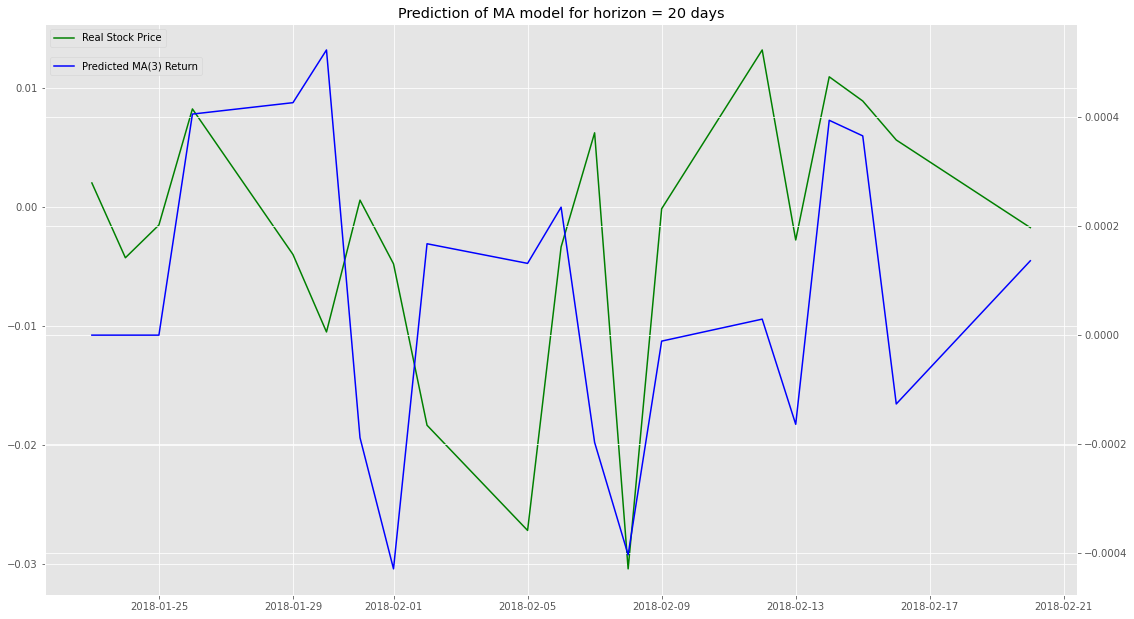

In [125]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_MA_S50 = prediction_MA_3(vol_MA_S50, horizon)

plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns_S50.index[T+1:T+1+horizon], test_data.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns_S50.index[T+1:T+1+horizon], resultat_MA_S50, color='blue', label='Predicted MA(3) Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of MA model for horizon = 20 days')
plt.show()

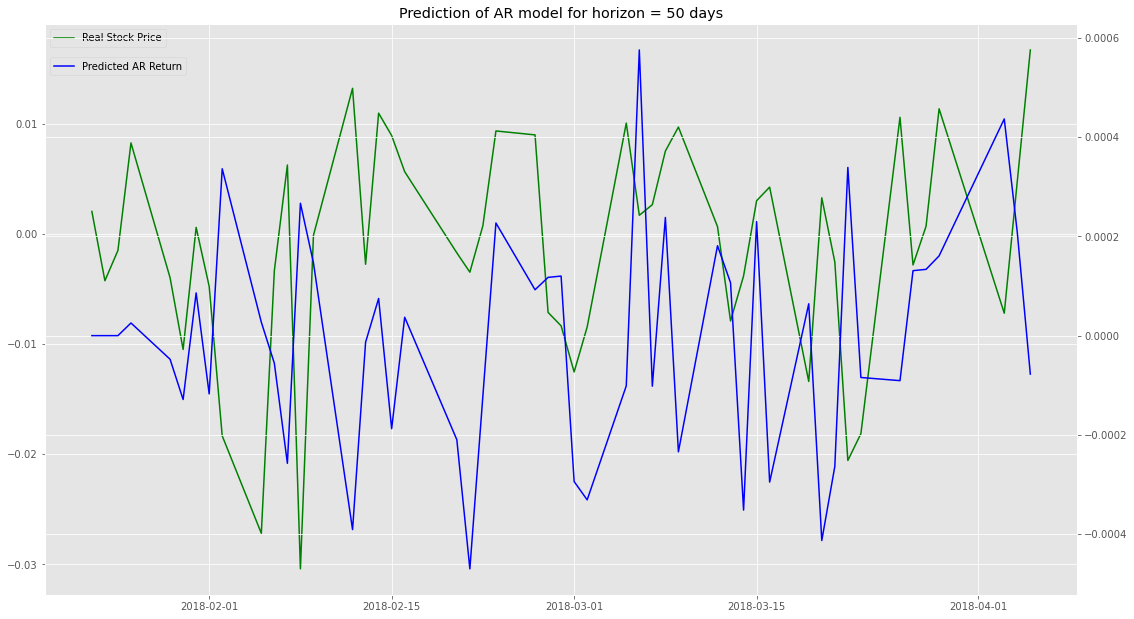

In [127]:
#Test horizon = 50 & comparaison graphique 
horizon = 50
resultat_MA_S50 = prediction_MA_3(vol_MA_S50, horizon)

plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], test_data.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_MA_S50, color='blue', label='Predicted AR Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of AR model for horizon = 50 days')
plt.show()

### III.2.2 - Simulation avec EGARCH(1,1) <a class="anchor" id="chapter3.section2.2"></a>
[Retour Sommaire](#sommaire)

Nous avons également réalisés des simulation à 20 jours avec le modèle EGARCH entrainé.
Nous rappellons ci-dessous l'équation du modèle EGARCH(1,1) utilisé pour réaliser la simulation.

#### Equation du modèle EGARCH(1,1) :
$$r(t) = \mu + \epsilon(t)$$
$$\epsilon(t) = \sigma(t)z(t)$$ 
$$log(\sigma²(t)) = \omega + \alpha(|z(t-1)| - E(|z(t-1)|)) + \nu * z(t-1) + \beta * \log(\sigma²(t-1))$$

<strong>NB :</strong> $ E(|z(t-1)|) = \sqrt(2/\pi) $ sous hypothèse de normalité
; avec z un bruit blanc standard gaussien

#### Liens utiles :
<https://vlab.stern.nyu.edu/docs/volatility/EGARCH> 

In [132]:
#fonction utilisant le modèle EGARCH(1,1) pour réaliser une prédiction sur une période donnée
def prediction_EGARCH(volatility, period):
    z=[np.random.standard_normal()]
    returns=[]
    sigma_t = volatility.iloc[-1]
    for i in range(period):
        sigma_forecast = np.sqrt(10**(omega + alpha*(abs(z[-1]) - np.sqrt(2/np.pi))+nu * z[-1]))* sigma_t **beta
        z_t=np.random.standard_normal()
        epsilon_forecast = sigma_forecast * z_t
        r_forecast = mu + epsilon_forecast
        returns.append(r_forecast)
        z.append(z_t)
        sigma_t= sigma_forecast
    return returns

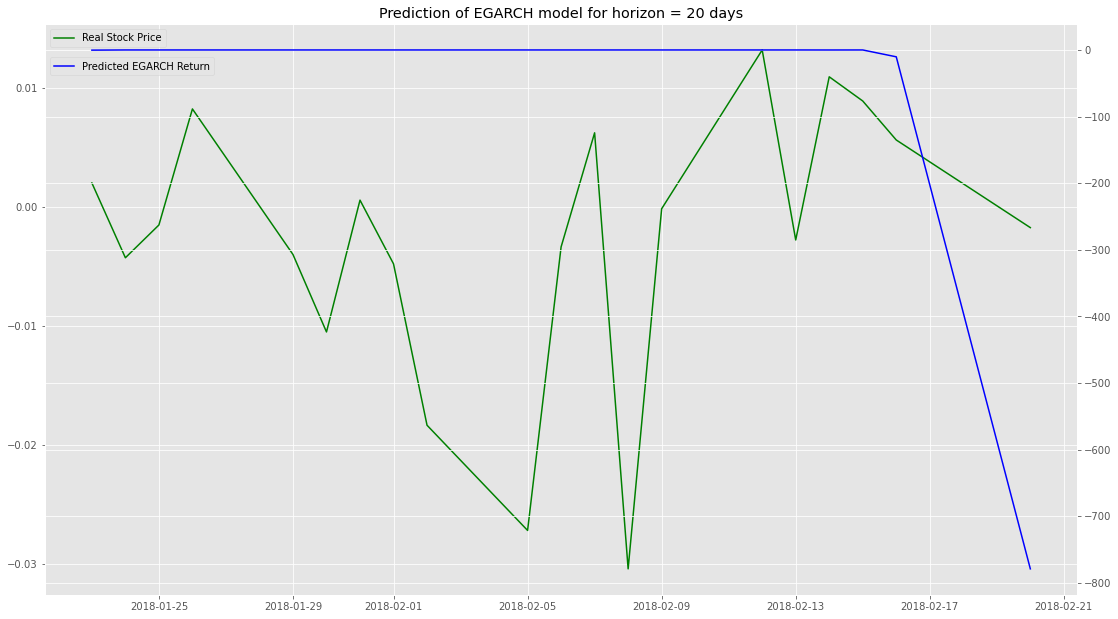

In [133]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_EGARCH = prediction_EGARCH(vol_egarch_S50, horizon)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], test_data.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_EGARCH, color='blue', label='Predicted EGARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of EGARCH model for horizon = 20 days')
plt.show()

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

### III.2.3 - Simulation avec GARCH(1,1) <a class="anchor" id="chapter3.section2.3"></a>
[Retour Sommaire](#sommaire)

#### Equation du modèle GARCH(1,1) :
$$r(t) = \mu + \epsilon(t)$$
$$\epsilon(t) = \sigma(t)z(t)$$ 
$$\sigma²(t) = \omega + \alpha * \epsilon²(t-1) + \beta * \epsilon²(t-1)$$
avec z un bruit blanc



In [136]:
#fonction utilisant le modèle GARCH(1,1) pour réaliser une prédiction sur une période donnée
def prediction_GARCH(volatility, period):
    returns=[]
    epsilon_t = 0
    sigma_t = volatility.iloc[-1]
    for i in range(period):
        sigma_forecast = np.sqrt(omega + alpha*epsilon_t **2 + beta*sigma_t **2)
        z_t=np.random.standard_normal()
        epsilon_forecast = sigma_forecast * z_t
        r_forecast = mu + epsilon_forecast
        returns.append(r_forecast)
        sigma_t= sigma_forecast
        epsilon_t = epsilon_forecast
    return returns

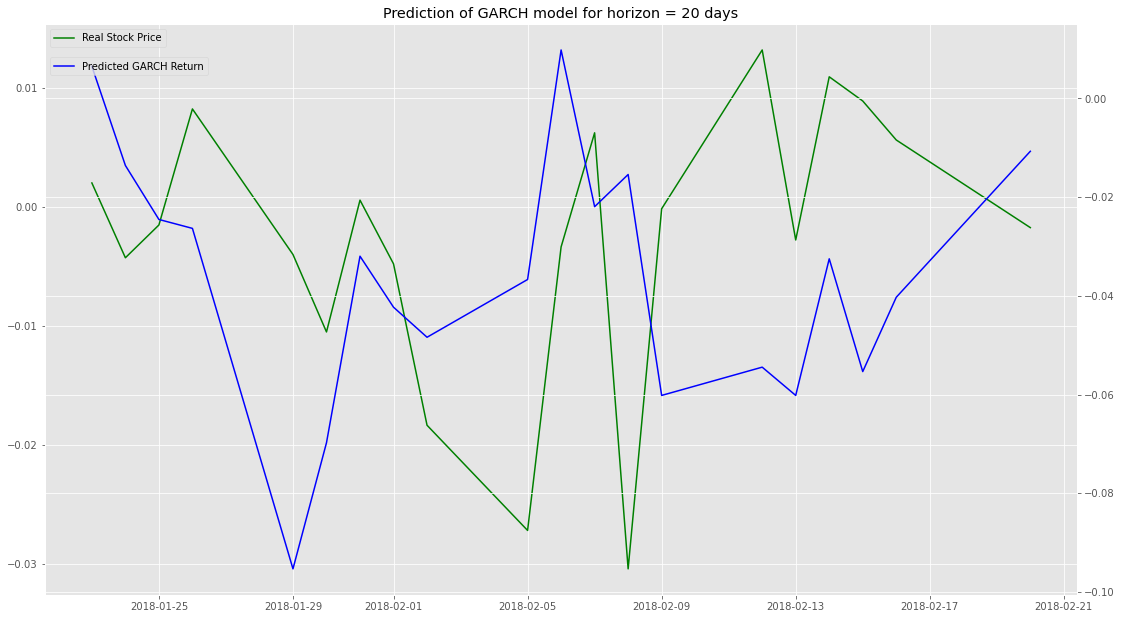

In [137]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_GARCH = prediction_GARCH(vol_garch_S50, horizon)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], test_data.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_GARCH, color='blue', label='Predicted GARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of GARCH model for horizon = 20 days')
plt.show()

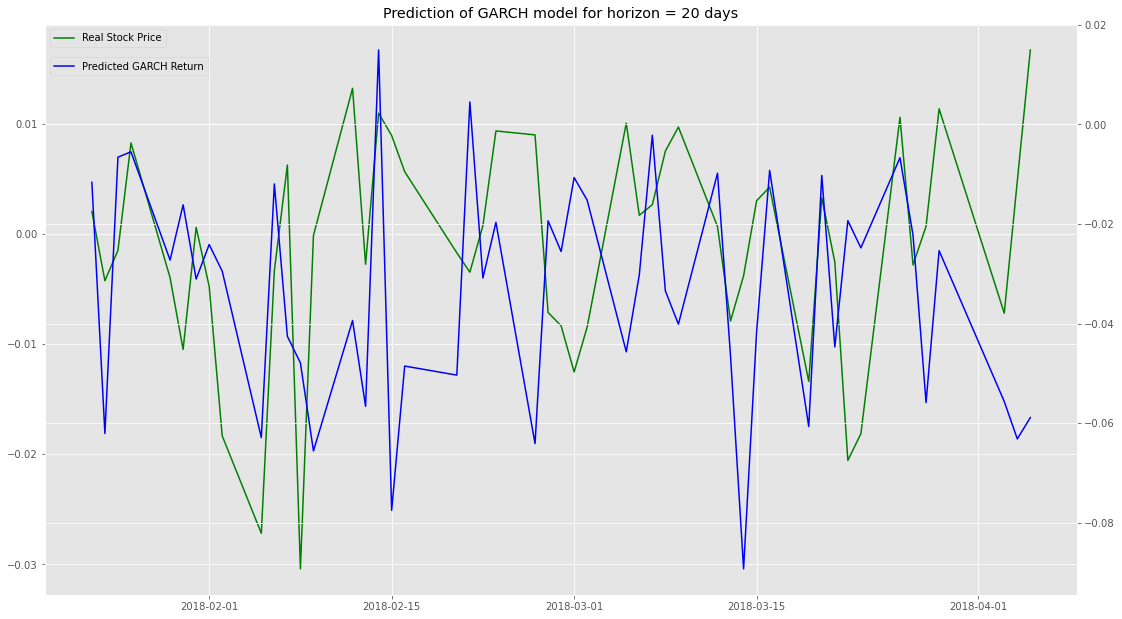

In [138]:
#Test horizon = 50
horizon = 50
resultat_GARCH = prediction_GARCH(vol_garch_S50, horizon)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], test_data.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_GARCH, color='blue', label='Predicted GARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of GARCH model for horizon = 20 days')
plt.show()

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## IV- Bootstrapping & 1ère analyse <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

#### IV.1 - Bootstrapping <a class="anchor" id="chapter4.section1"></a>

On réalise un bootstrapping sur notre <strong> portfeuille de valeurs </strong> (50% STOXX50 / 50% S&P500). Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set (par la suite, nous réaliserons plutôt 5000 scénarios à minima).

In [40]:
portfolio_bootstrapping = (1+pd.DataFrame([random.choices(list(
    training_data.values), k=len(data.index)-T-1) for i in 
    range(1000)]).T.shift(1).fillna(0)).cumprod()


portfolio_bootstrapping.index = test_data.index

On peut ensuite visualiser l'ensemble de notre nuage de scénarios sur un graphique :

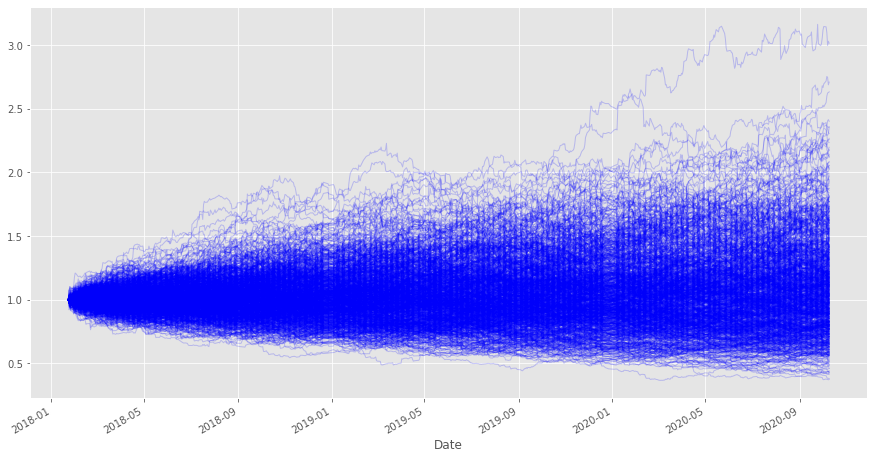

In [41]:
portfolio_bootstrapping.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2, color='b')

In [42]:
# Affichage : On peut également afficher le bootstrapping réalisé sous la forme de tableau pour contrôle.
print(portfolio_bootstrapping)

                 0         1         2         3         4         5    \
Date                                                                     
2018-01-23  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2018-01-24  0.985066  1.001490  0.995816  1.018137  0.992899  1.002257   
2018-01-25  0.987589  1.004406  0.995997  1.018694  1.002137  1.008879   
2018-01-26  0.971355  1.009539  1.011580  0.986702  1.013210  0.990014   
2018-01-29  0.975729  1.016253  1.022669  0.974784  1.015973  0.996016   
...              ...       ...       ...       ...       ...       ...   
2020-10-05  0.692264  1.428230  1.082388  0.923209  1.053291  1.000394   
2020-10-06  0.688798  1.447634  1.087982  0.927112  1.031568  1.023732   
2020-10-07  0.685322  1.432702  1.098343  0.918948  1.039828  1.037299   
2020-10-08  0.678681  1.420546  1.075692  0.920793  1.037790  1.028291   
2020-10-09  0.683634  1.425039  1.080328  0.928181  1.041069  1.029795   

                 6         7         

#### IV.2 - 1ère analyse <a class="anchor" id="chapter4.section2"></a>

On commence par retourner <strong>la moyenne des rendements logarithmiques </strong> de l'ensemble de nos scénarios générés par bootstrapping.

$$ Return(t) = \ln(1 + r_{t}) $$

In [43]:
#On calcul le pourcentage de variation entre t et t-1 pour tous les scénarii générés
r_bootstrapping = portfolio_bootstrapping.pct_change().dropna()

#On passe au logarithme pour obtenir des rendements pour tous les scénarii
returns_bootstrapping = np.log(1 + r_bootstrapping)

#On passe à la moyenne à chaque instant t de tous les scénarios générés
mean_returns_bootstrapping = returns_bootstrapping.mean()

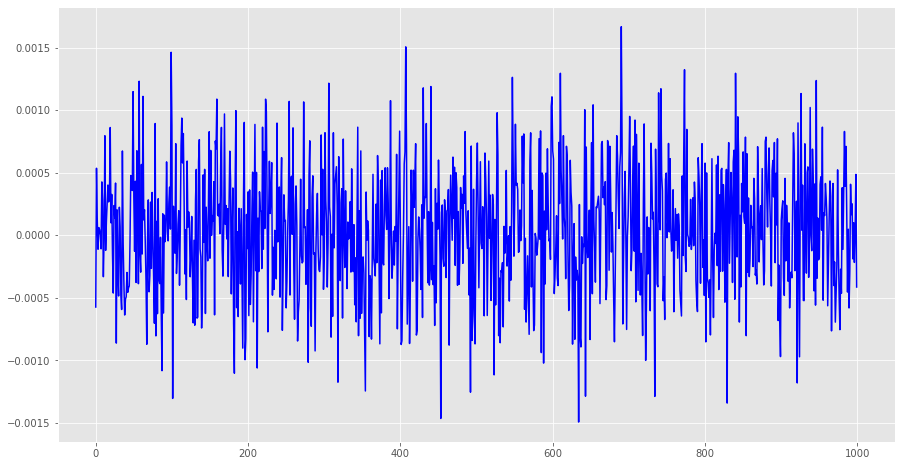

In [44]:
mean_returns_bootstrapping.plot(figsize=(15,8), legend=False,color='b')

On observe que la moyenne est globalement constante. Par la suite, on utilisera la moyenne des rendements (normés) sans logarithme.

On calcule ensuite sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

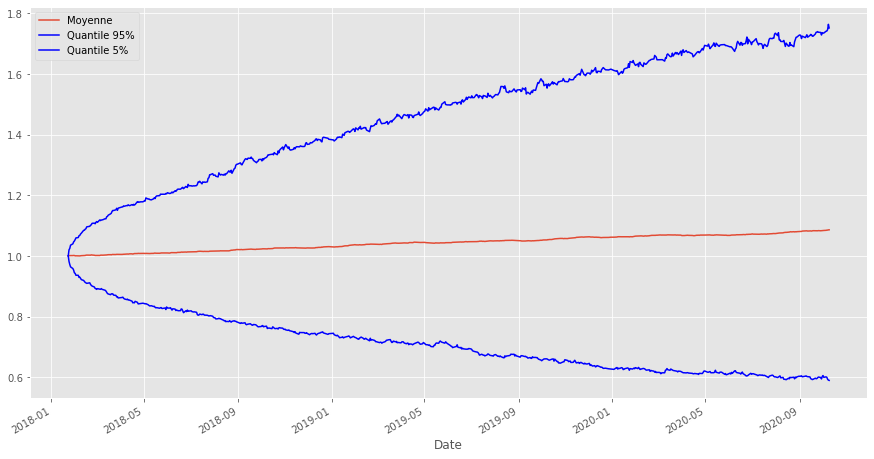

In [45]:
#Calcul des valeurs
Valeur_quantile = 0.95
Quantile_min = portfolio_bootstrapping.quantile(1-Valeur_quantile,1)
Quantile_max = portfolio_bootstrapping.quantile(Valeur_quantile,1)
Moyenne = portfolio_bootstrapping.mean(1)

#Affichage du graphique 
Moyenne.plot(label='Moyenne',figsize=(15,8))
Quantile_min.plot(label='Quantile 95%',color='b')
Quantile_max.plot(label='Quantile 5%',color='b')
plt.legend()

#### IV.3 - Comparaison avec les valeurs réelles <a class="anchor" id="chapter4.section3"></a>

Nous voulons maintenant comparer nos simulations avec les valeurs réelles de notre portfolio.
Pour cela, nous réalisons tout d'abord un dataframe contenant : 

- Les valeurs réelles
- La moyenne des scénarios simulés
- Le quantile à 5% des scénarios simulés
- Le quantile à 95% des scénarios simulés


In [46]:
#de base on a portfolio ici, donc je le rajoute au cas où
#portfolio = (data.dropna().mean(axis=1) + 1).cumprod()


prediction=pd.DataFrame({'Real Data' : list(data_pf.iloc[T+1:,2]), 'Simulated Data' : list(Moyenne),'Quantile 5%' : list(Quantile_min),'Quantile 95%':list(Quantile_max)}, index=test_data.index)
prediction = prediction/prediction.iloc[0, :]

Nous représentons le tout dans le graphique ci-dessous : 

In [47]:
temps=list(range(0,len(prediction.index)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=temps, y=list(Moyenne), name="Simulated Data (moyenne)",
                        line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=temps, y=prediction.iloc[:,0], name="Real Data",
                        line_color='royalblue'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_min), name="Quantile",
                        line_color='dimgray'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_max), name="Quantile",
                        line_color='dimgray'))
fig.update_layout(title_text='portfolio',xaxis_rangeslider_visible=True)
fig.show()

## V - Fonction Prediction_Boostrapping <a class="anchor" id="chapter5"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu "automatiser" l'ensemble des actions réalisées précédement au sein d'une seule et unique fonction. Cette fonction prend pour paramètres <strong> un set de données </strong> au format DataFrame, le <strong> nombre de scenario </strong> générés par boostrapping, ainsi qu'un <strong> horizon </strong> qui est une nombre (integer) correspondant à la durée de la simulation que l'on va réaliser.

Ci-dessous la fonction : 

In [48]:
def prediction_bootstrapping(data,n_scenario,horizon):
    #départ à 1
    data = data/data.iloc[0, :]
    returns = data.pct_change().dropna().mean(axis=1)
    portfolio = (data.pct_change().dropna().mean(axis=1) + 1).cumprod()
    portfolio_bootstrapping = (1+pd.DataFrame([random.choices(list(returns.values), k=horizon) for i in range(n_scenario)]).T.shift(1).fillna(0)).cumprod()
    portfolio_bootstrapping.index = pd.date_range(data.index[-1],periods = horizon,freq='D')
        #plt.subplot(311)
        #portfolio_bootstrapping.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2, color='b')
        #plt.title('Prédictions Bootstrap')
    Valeur_quantile = 0.95
    
    #Création des courbes de prédictions
    Quantile_min = portfolio_bootstrapping.quantile(1-Valeur_quantile,1)
    Quantile_max = portfolio_bootstrapping.quantile(Valeur_quantile,1)
    Moyenne = portfolio_bootstrapping.mean(1)
    plt.subplot(211)
    Moyenne.plot(label='Moyenne',figsize=(15,8))
    Quantile_min.plot(label='Quantile 95%',color='b')
    Quantile_max.plot(label='Quantile 5%',color='b')
    plt.legend()
    plt.title('Courbes de prédictions')
    
    #Création des courbes totales
        #Moyenne = portfolio.append(Moyenne+portfolio[-1]-1)
        #Quantile_min = portfolio.append(Quantile_min+portfolio[-1]-1)
        #Quantile_max = portfolio.append(Quantile_max+portfolio[-1]-1)
    plt.subplot(212)
    (Moyenne+portfolio[-1]-1).plot(label='Moyenne',figsize=(15,8),color='r')
    (Quantile_min+portfolio[-1]-1).plot(label='Quantile 95%',color='b')
    (Quantile_max+portfolio[-1]-1).plot(label='Quantile 5%',color='b')
    portfolio.plot(label='Data',color ='black')
    plt.legend()
    plt.title('Courbes d évolution du portefeuille')
    
    return((Moyenne), Quantile_min, Quantile_max, len(Moyenne))
   

Nous pouvons maintenant effectuer un test de cette fonction. On constate que les résultats sont équivalents à ceux obtenus dans la partie 3.

En outre, cette fonction permet aussi d'obtenir une visualisation globale de l'évolution du portefeuille, en superposant la partie de training, les différentes simulations (Q5% Q95% et moyenne) ainsi que la valeur du testing set (correspondant au réel).

(2020-10-09    1.000000
 2020-10-10    1.000264
 2020-10-11    1.000555
 2020-10-12    1.000751
 2020-10-13    1.001052
 2020-10-14    1.001167
 2020-10-15    1.001283
 2020-10-16    1.001430
 2020-10-17    1.001686
 2020-10-18    1.001774
 2020-10-19    1.001795
 2020-10-20    1.001776
 2020-10-21    1.001866
 2020-10-22    1.002004
 2020-10-23    1.002153
 2020-10-24    1.002003
 2020-10-25    1.002377
 2020-10-26    1.002597
 2020-10-27    1.002912
 2020-10-28    1.003093
 2020-10-29    1.003184
 2020-10-30    1.003518
 2020-10-31    1.003548
 2020-11-01    1.003825
 2020-11-02    1.004146
 2020-11-03    1.004117
 2020-11-04    1.004308
 2020-11-05    1.004440
 2020-11-06    1.004654
 2020-11-07    1.005109
 2020-11-08    1.005325
 2020-11-09    1.005716
 2020-11-10    1.006008
 2020-11-11    1.006314
 2020-11-12    1.006486
 2020-11-13    1.006802
 2020-11-14    1.006998
 2020-11-15    1.007218
 2020-11-16    1.007530
 2020-11-17    1.007763
 2020-11-18    1.007932
 2020-11-19    1

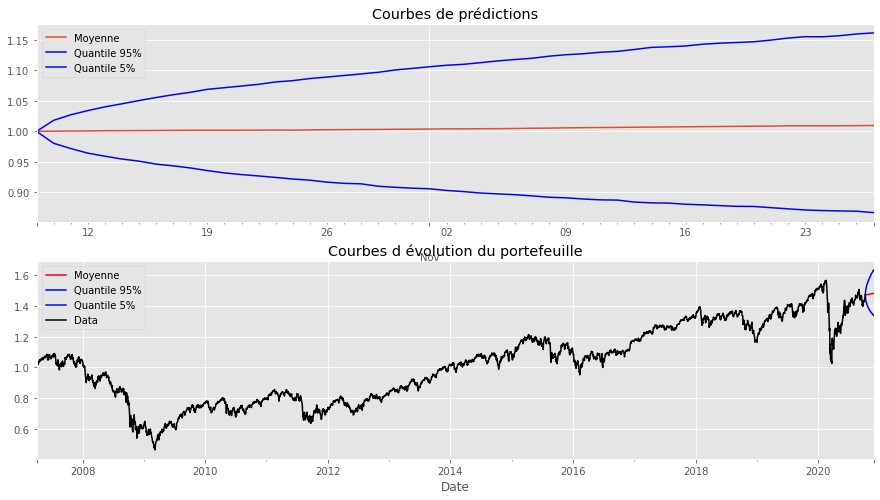

In [49]:
prediction_bootstrapping(data,10000,50)

## VI - Fonction de performance <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

#### VI.1 - Fonctions de mesures <a class="anchor" id="chapter6.section1"></a>

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisé de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [50]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [51]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [52]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)

Nous avons ensuite choisi 3 mesures permettant de calculer la distance entre deux distributions de fonctions : 

- la distance d'Hellinger
- la distance de Kullback-Leiber
- la distance de Bhattacharyya

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [144]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from scipy import stats

def Z_score(u_values) :
    return scipy.stats.zscore(u_values)

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [146]:
#  ! WARNING ! -> This function calculates the t-Score of twodistribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from scipy import stats

def t_score(u_values, v_values) :
    return stats.ttest_ind(u_values, v_values)

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [143]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(u_values , v_values):
    return f_oneway(u_values , v_values)

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [148]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from scipy.stats import mannwhitneyu

def Mann_Whitneyu(u_values , v_values) :
    return scipy.stats.mannwhitneyu(u_values , v_values)

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [147]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import wasserstein_distance

def Wasserstein(u_values , v_values) :
    return (scipy.stats.wasserstein_distance(u_values , v_values))

#### VI.2 - Fonction Describe <a class="anchor" id="chapter6.section2"></a>

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

In [56]:
def describe(data):
    res = data.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
    res.loc['Median Absolute Deviation'] = Median_Abs_dev(data) #Add MAD measurement to the recap table
    res.loc['skew'] = skewness(data)                                   #Add skew measurement to the recap table
    res.loc['kurtosis'] = kurtosis(data)                               #Add kurtosis measurement to the recap table
    
    # Marche uniquement si notre Dataframe à 2 indices ou plus
    if len(data.columns) > 1 : 
        res.loc['Hellinger Distance'] = hellinger(data)
        res.loc['Kullback_Leiber Distance'] = Kullback_Leiber(data)
        res.loc['Bhattacharyya Distance'] = Bhattacharyya(data)
    
    return res

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés
- Le quantile 5% de nos scénarii générés
- Le quantile 95% de nos scénarii générés

In [57]:
describe(prediction)

<ipython-input-55-d192eaf1ad6c>:14: RuntimeWarning:

invalid value encountered in sqrt



Real Data  Simulated Data  Quantile 5%  \
count                      663.000000      663.000000   663.000000   
mean                         0.963392        1.042771     0.709911   
std                          0.062270        0.024214     0.091700   
min                          0.725332        0.999744     0.589323   
25%                          0.933948        1.022078     0.626106   
50%                          0.962544        1.044370     0.701656   
75%                          1.001110        1.065485     0.770263   
max                          1.113633        1.085838     1.000000   
Median Absolute Deviation    0.046377        0.020770     0.076268   
skew                        -0.379294       -0.162665     0.678269   
kurtosis                     1.031482       -1.178842    -0.360543   
Hellinger Distance           0.000000        0.918797     2.846045   
Kullback_Leiber Distance     0.000000      -21.431361    88.138304   
Bhattacharyya Distance       0.000000             NaN          NaN   

                           Quantile 95%  
count                        663.000000  
mean                           1.466620  
std                            0.192920  
min                            1.000000  
25%                            1.319327  
50%                            1.500058  
75%                            1.636771  
max                            1.763319  
Median Absolute Deviation      0.164943  
skew                          -0.412950  
kurtosis                      -0.946798  
Hellinger Distance             4.383377  
Kullback_Leiber Distance    -114.100623  
Bhattacharyya Distance        -5.964553

On observe évidemment ici que la moyenne est la simulation qui a les paramètres les plus proches de ceux de la distribution du testing set. En revanche, on peut remarquer que le quantile 5% représente mieux la distribution réelle que le quantile à 95%.

NB : On peut voir que la distance de Bhattacharyya ne fonctionne pas pour le quantile 5% => racine de nombre négatif, à modifier.

Ci-dessous, nous avons tracé les distributions des valeurs réelles et celle de la moyenne des scénarios générés.

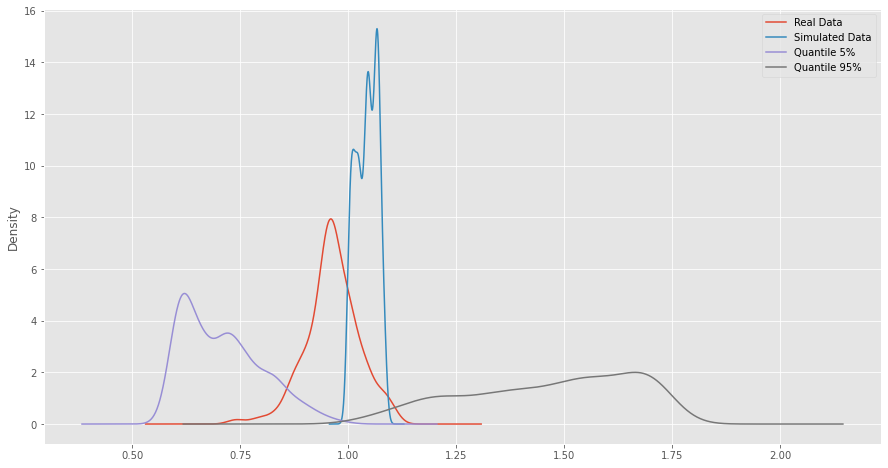

In [58]:
prediction[['Real Data','Simulated Data', 'Quantile 5%', 'Quantile 95%']].plot.density(figsize=(15,8))

On remarque en effet que la distribution du quantile à 5% est plus ressemblante à celle de la distribution réelle.

#### VI.3 - Comparaison des prévisions par boostrapping et des modèles AR(1), GARCH(1,1) et AR(1)-GARCH(1,1) <a class="anchor" id="chapter6.section3"></a>
[Retour Sommaire](#sommaire)

#### Vincent :  A réinjecter dans la partie III.1.1 pour justifier nos modèles et trouver le plus pertinent

In [61]:
import pmdarima as pm                                        #Use in section III.1.1
from pmdarima.arima import ARIMA                             #Use in section III.1.1

In [ ]:
#The Auto-arima function will propose the best Arma-GARCH model for our returns
def best_param_ARIMA(training_data,pmax,qmax):
    stepwise_fit = pm.auto_arima(training_data, start_p=1, start_q=1, pmax=3, qmax=3, m=0,
                             start_P=0, seasonal=True, d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    return(stepwise_fit.summary())

In [ ]:
daily_fit = ARIMA(order=(X, X, X), seasonal_order=(0, 0, 0, 12)).fit(training_data)

####   Vincent : Idem pour l'auto GARCH !

On rappel le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela veut dire que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [59]:
def best_param_garch(training_data,pmax,qmax):
    best_pq=[0,0]
    AIC = 0
    for p in range(1,pmax+1):
        for q in range(qmax+1):
            model = arch_model(training_data,p=p,q=q,rescale=False)
            fit = model.fit(update_freq=5,disp='off')
            if fit.aic<AIC:
                AIC = fit.aic
                best_pq[0]=p
                best_pq[1]=q
    return(best_pq)

In [ ]:
# GARCH Model (with constant mean)

[p,q] = best_param_garch(training_data,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

simple_garch = arch_model(simple_returns,p=p,q=q,rescale=False)
simple_garch_fitted = simple_garch.fit(update_freq=5,disp='off')
print(simple_garch_fitted.summary())

## VII - Filtred Historical Simulation <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

Etape 1 : Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

In [60]:
# GARCH Model (with constant mean)

[p,q] = best_param_garch(training_data,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

simple_garch = arch_model(simple_returns,p=p,q=q,rescale=False)
simple_garch_fitted = simple_garch.fit(update_freq=5,disp='off')
print(simple_garch_fitted.summary())

NameError: name 'simple_returns' is not defined

Etape 2 : Standardisation des rendements

Etape 3 : Simulation de la volatilité journalière par notre modèle GARCH

Etape 4 : Production d'un jeu de rendement standardisé et i.i.d 

Pour cela, on divise les rendements réalisés par les volatilités simulées par notre modèle GARCH.

Etape 5 : Boostrapping réalisé à l'horizon de la simulation voulue